# EYE FOR BLIND

In [1]:
!pip install gTTS

  Obtaining dependency information for gTTS from https://files.pythonhosted.org/packages/59/a8/e3434904445eacf03b857ac001755d8ffac49b4f3339d63592b4eda009dc/gTTS-2.5.1-py3-none-any.whl.metadata


In [2]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from collections import Counter
from tqdm import tqdm
import time
from IPython import display

import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model
from gtts import gTTS

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data understanding
1. Importing the dataset and read image & captions into two seperate variables

2. Visualising both the images & text present in the dataset

3. Creating a dataframe which summarizes the image, path & captions as a dataframe

4. Creating a list which contains all the captions & path

5. Visualising the top 30 occuring words in the captions

### Importing the dataset and reading image & captions into two seperate variables

In [3]:
images= '/kaggle/input/Images/'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


### Visualising the image & text present in the dataset

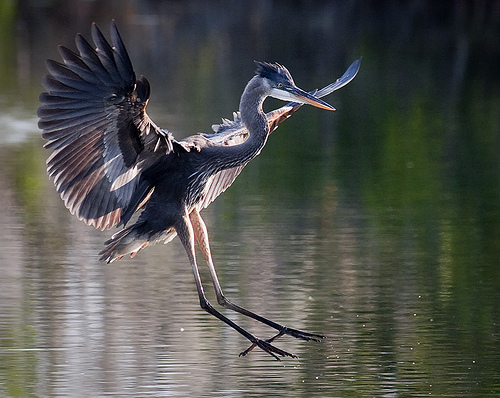

In [4]:
Image.open(all_imgs[4321])

In [5]:
def load_doc(filename):
    with open(filename) as f:
        text = f.read()
    return text

text_file = '/kaggle/input/captions.txt'
doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


### Creating a dataframe which summarizes the image, path & captions as a dataframe



Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [7]:
all_img_id= []
all_img_vector= []
annotations= []

file = doc.splitlines()[1:]
for line in file:
    split=line.index(",")
    ids = line[:split]
    caption = line[split+1:]
    all_img_id.append(ids)
    annotations.append(caption)
    all_img_vector.append('/kaggle/input/Images/'+ids)

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df.head()

ID                                            Path  \
0  1000268201_693b08cb0e.jpg  /kaggle/input/Images/1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg  /kaggle/input/Images/1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg  /kaggle/input/Images/1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg  /kaggle/input/Images/1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg  /kaggle/input/Images/1000268201_693b08cb0e.jpg   

                                            Captions  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [8]:
#Creating the vocabulary & the counter for the captions

vocabulary = [word.lower() for line in annotations for word in line.split()]

val_count = Counter(vocabulary)
val_count.most_common(10)

[('a', 61752),
 ('.', 34212),
 ('in', 18965),
 ('the', 18249),
 ('on', 10732),
 ('is', 9345),
 ('and', 8851),
 ('dog', 8126),
 ('with', 7761),
 ('man', 7238)]

### Visualising the top 30 occuring words in the captions

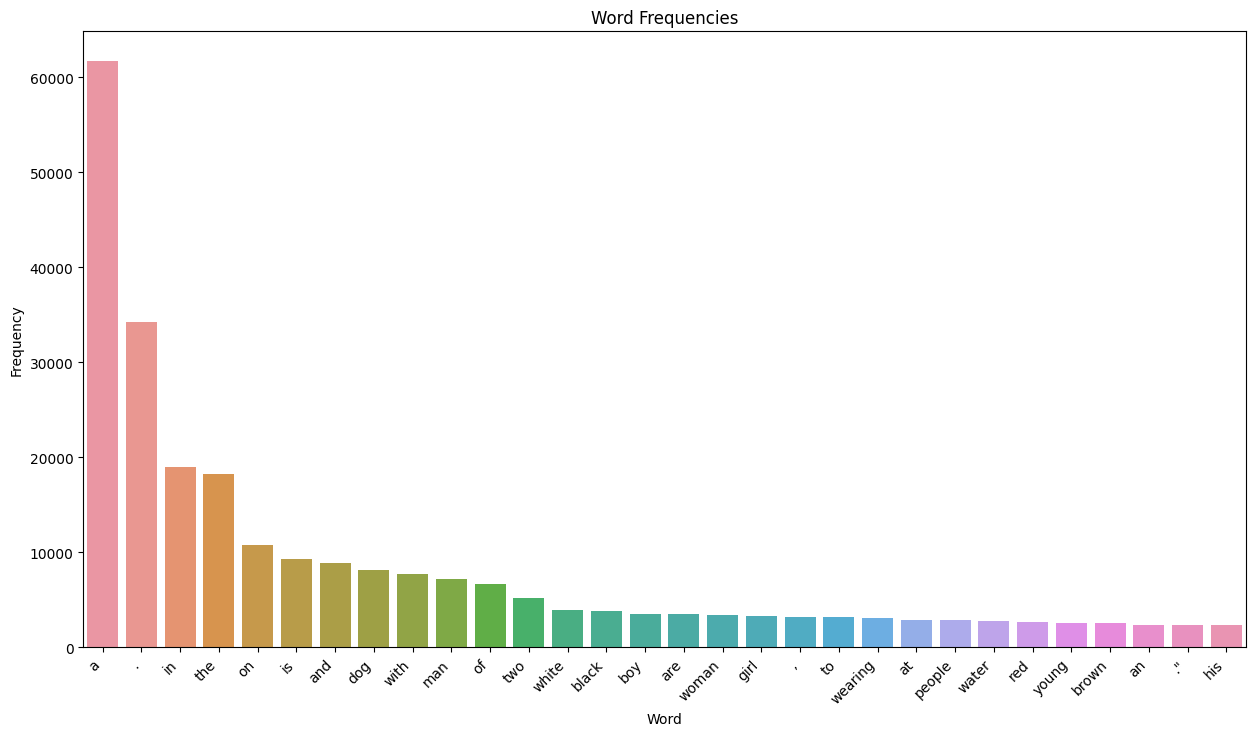

In [9]:
temp_df = pd.DataFrame(val_count.most_common(30), columns = ['Word', 'Frequency'])
plt.figure(figsize=(15,8))
sns.barplot(x='Word', y='Frequency', data=temp_df)
plt.title('Word Frequencies')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

In [10]:
#Creating a list that will contain all the captions
annotations = df.Captions.map(lambda x : '<start> '+x+' <end>').to_list()

#list that contains all the path to the images
all_img_path = df.Path.to_list()

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


# Pre-Processing the captions
1. Creating the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. This gives us a vocabulary of all of the unique words in the data. Keeping the total vocaublary to top 5,000 words for saving memory.

2. Replacing all other words with the unknown token "UNK" .

3. Creating word-to-index and index-to-word mappings.

4. Pading all sequences to be the same length as the longest one.

In [11]:
# creating the tokenizer
top_word_count = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_count,oov_token= "<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

In [12]:
# Creating word-to-index and index-to-word mappings.
tokenizer.fit_on_texts(annotations)

train_seqs = tokenizer.texts_to_sequences(annotations)

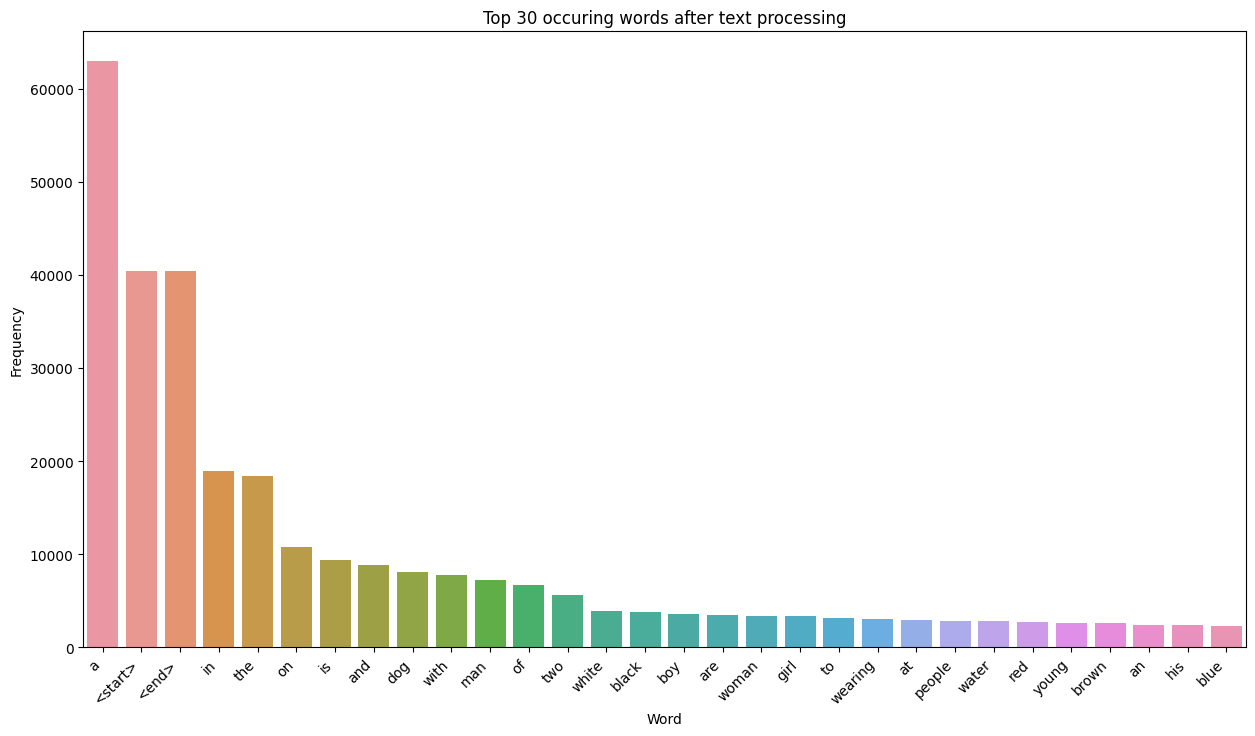

In [13]:
# Creating a word count of the tokenizer to visulize the Top 30 occuring words after text processing

word_count_df = pd.DataFrame([tokenizer.word_counts]).T.reset_index()
word_count_df = word_count_df.sort_values(by=0,ascending=False).head(30).reset_index(drop=True).rename(columns={"index":"words",0:"counts"})

plt.figure(figsize=(15,8))
sns.barplot(x='words', y='counts', data=word_count_df)
plt.title('Top 30 occuring words after text processing')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

In [14]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
train_seqs_len = [len(seq) for seq in train_seqs]

longest_word_len = max(train_seqs_len)

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding= 'post', maxlen = longest_word_len)

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


# Pre-processing the images

1. Resizing them into the shape of (299, 299)

2. Normalizing the image within the range of -1 to 1, such that it is in correct format for InceptionV3.

In [15]:
def load_and_process_image(file_path, target_size=(299, 299)):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, target_size)
    img = tf.keras.applications.inception_v3.preprocess_input(img) # rest of the preprocessing is handle by this 
    
    return img, file_path

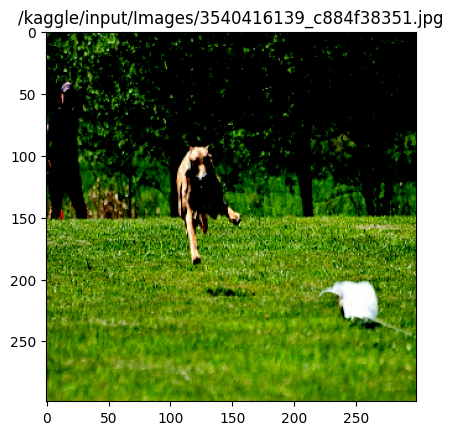

In [16]:
index = 2308

# Load and process the image using the function
processed_img, file_path = load_and_process_image(all_imgs[index])

# Display the processed image along with its file path
plt.imshow(processed_img)
plt.title(file_path)
plt.show()

In [17]:
encode_train_set = sorted(set(all_img_vector))

feature_dict = {}

image_data_set = tf.data.Dataset.from_tensor_slices(encode_train_set)
image_data_set = image_data_set.map(load_and_process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)
image_data_set

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

# Loading the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extracting the features of the images using the last layer of pre-trained model.

2.The shape of the output of this layer is 8x8x2048. 

3.Using a function to extract the features of each image in the train & test dataset such that the shape of each image is (batch_size, 8*8, 2048)

In [18]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = keras.Model(new_input, hidden_layer)

87910968/87910968 [==============================] - 1s 0us/step


In [19]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalization[0][0

In [20]:
for image,path in tqdm(image_data_set):
    batch_features = image_features_extract_model(image)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for batch_f, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  batch_f.numpy()

100%|██████████| 253/253 [01:01<00:00,  4.10it/s]


In [21]:
batch_f.shape

TensorShape([64, 2048])

# Dataset creation
1. Applying train_test_split on both image path & captions to create the train & test list and creating the train-test split using 80-20 ratio & random state = 42

2. Creating a function which maps the image path to their feature. 

3. Builder function to create train & test dataset & apply the function created earlier to transform the dataset

In [22]:
path_train, path_test, cap_train, cap_test = train_test_split( all_img_vector, cap_vector, test_size = 0.9, random_state = 42)

In [23]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 4045
Testing data for images: 36410
Training data for Captions: 4045
Testing data for Captions: 36410


In [24]:
# This function will take the image_path & caption and return it's feature & respective caption.
def map_func(image_name,caption):
    img_tensor = feature_dict[image_name.decode('utf-8')]
    return img_tensor,caption

In [25]:
# Builder function to create dataset which takes in the image path & captions as input
# This function transforms the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
BATCH_SIZE = 32
BUFFER_SIZE = 1000
def gen_dataset(images_data, captions_data):
    
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return dataset

In [26]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [27]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(32, 64, 2048)
(32, 39)


# Model Building
1. Setting the parameters

2. Building the Encoder, Attention model & Decoder

In [28]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_train) // BATCH_SIZE

### Encoder

In [29]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)
        
    def call(self, features):
        features = self.dense(features)
        features =  tf.keras.activations.relu(features)
        
        return features

In [30]:
encoder=Encoder(embedding_dim)

### Attention model

In [31]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units=units

    def call(self, features, hidden):

        hidden_with_time_axis = hidden[:, tf.newaxis]
        
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1)

        context_vector = attention_weights * features

        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

### Decoder

In [32]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) 
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) 
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) 
        self.d2 = tf.keras.layers.Dense(vocab_size)
    
    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) 
        embed = self.embed(x) 
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1)
        output,state = self.gru(embed) 
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) 
        output = self.d2(output) 
        
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [33]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [34]:
features = encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights = decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


# Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [35]:
optimizer = tf.keras.optimizers.Adam()  #optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, 
                                                            reduction = tf.keras.losses.Reduction.NONE) #loss object

In [36]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [37]:
#checkpoint path
checkpoint_path = "Flick8k/checkpoint/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [38]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [39]:
#training & testing step functions
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss, avg_loss

In [40]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, avg_loss

In [41]:
#loss function for the test dataset
def test_loss_cal(test_dataset):
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
    
    return avg_test_loss

In [42]:
loss_plot = []
test_loss_plot = []
EPOCHS = 50

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/50 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.612, & test loss is 9.819
Time taken for 1 epoch 257.1278021335602 sec

Test loss has been reduced from 100.000 to 9.819


  4%|▍         | 2/50 [06:03<2:14:45, 168.45s/it]

For epoch: 2, the train loss is 0.983, & test loss is 8.259
Time taken for 1 epoch 106.07448625564575 sec

Test loss has been reduced from 9.819 to 8.259


  6%|▌         | 3/50 [07:48<1:49:12, 139.41s/it]

For epoch: 3, the train loss is 0.887, & test loss is 7.583
Time taken for 1 epoch 104.69414281845093 sec

Test loss has been reduced from 8.259 to 7.583


  8%|▊         | 4/50 [09:34<1:36:46, 126.24s/it]

For epoch: 4, the train loss is 0.824, & test loss is 7.084
Time taken for 1 epoch 105.88472485542297 sec

Test loss has been reduced from 7.583 to 7.084


 10%|█         | 5/50 [11:19<1:28:52, 118.51s/it]

For epoch: 5, the train loss is 0.770, & test loss is 6.657
Time taken for 1 epoch 104.64360880851746 sec

Test loss has been reduced from 7.084 to 6.657


 12%|█▏        | 6/50 [13:04<1:23:32, 113.93s/it]

For epoch: 6, the train loss is 0.726, & test loss is 6.278
Time taken for 1 epoch 104.86502146720886 sec

Test loss has been reduced from 6.657 to 6.278


 14%|█▍        | 7/50 [14:49<1:19:35, 111.06s/it]

For epoch: 7, the train loss is 0.685, & test loss is 5.946
Time taken for 1 epoch 104.97762274742126 sec

Test loss has been reduced from 6.278 to 5.946


 16%|█▌        | 8/50 [16:34<1:16:20, 109.05s/it]

For epoch: 8, the train loss is 0.647, & test loss is 5.625
Time taken for 1 epoch 104.60178136825562 sec

Test loss has been reduced from 5.946 to 5.625


 18%|█▊        | 9/50 [18:18<1:13:34, 107.68s/it]

For epoch: 9, the train loss is 0.614, & test loss is 5.338
Time taken for 1 epoch 104.4897072315216 sec

Test loss has been reduced from 5.625 to 5.338


 20%|██        | 10/50 [20:03<1:11:09, 106.74s/it]

For epoch: 10, the train loss is 0.581, & test loss is 5.077
Time taken for 1 epoch 104.47956109046936 sec

Test loss has been reduced from 5.338 to 5.077


 22%|██▏       | 11/50 [21:48<1:08:57, 106.08s/it]

For epoch: 11, the train loss is 0.551, & test loss is 4.830
Time taken for 1 epoch 104.427818775177 sec

Test loss has been reduced from 5.077 to 4.830


 24%|██▍       | 12/50 [23:32<1:06:54, 105.65s/it]

For epoch: 12, the train loss is 0.525, & test loss is 4.622
Time taken for 1 epoch 104.47100353240967 sec

Test loss has been reduced from 4.830 to 4.622


 26%|██▌       | 13/50 [25:17<1:04:59, 105.39s/it]

For epoch: 13, the train loss is 0.499, & test loss is 4.415
Time taken for 1 epoch 104.61985039710999 sec

Test loss has been reduced from 4.622 to 4.415


 28%|██▊       | 14/50 [27:01<1:03:02, 105.08s/it]

For epoch: 14, the train loss is 0.480, & test loss is 4.231
Time taken for 1 epoch 104.21148824691772 sec

Test loss has been reduced from 4.415 to 4.231


 30%|███       | 15/50 [28:46<1:01:10, 104.87s/it]

For epoch: 15, the train loss is 0.456, & test loss is 4.049
Time taken for 1 epoch 104.18677353858948 sec

Test loss has been reduced from 4.231 to 4.049


 32%|███▏      | 16/50 [30:30<59:22, 104.78s/it]  

For epoch: 16, the train loss is 0.436, & test loss is 3.903
Time taken for 1 epoch 104.41634035110474 sec

Test loss has been reduced from 4.049 to 3.903


 34%|███▍      | 17/50 [32:15<57:35, 104.71s/it]

For epoch: 17, the train loss is 0.423, & test loss is 3.775
Time taken for 1 epoch 104.39645671844482 sec

Test loss has been reduced from 3.903 to 3.775


 36%|███▌      | 18/50 [33:59<55:49, 104.67s/it]

For epoch: 18, the train loss is 0.406, & test loss is 3.631
Time taken for 1 epoch 104.38938212394714 sec

Test loss has been reduced from 3.775 to 3.631


 38%|███▊      | 19/50 [35:44<54:05, 104.69s/it]

For epoch: 19, the train loss is 0.391, & test loss is 3.519
Time taken for 1 epoch 104.57432293891907 sec

Test loss has been reduced from 3.631 to 3.519


 40%|████      | 20/50 [37:29<52:19, 104.66s/it]

For epoch: 20, the train loss is 0.381, & test loss is 3.411
Time taken for 1 epoch 104.41332077980042 sec

Test loss has been reduced from 3.519 to 3.411


 42%|████▏     | 21/50 [39:13<50:31, 104.55s/it]

For epoch: 21, the train loss is 0.365, & test loss is 3.296
Time taken for 1 epoch 104.12573885917664 sec

Test loss has been reduced from 3.411 to 3.296


 44%|████▍     | 22/50 [40:58<48:49, 104.61s/it]

For epoch: 22, the train loss is 0.359, & test loss is 3.216
Time taken for 1 epoch 104.58266854286194 sec

Test loss has been reduced from 3.296 to 3.216


 46%|████▌     | 23/50 [42:42<47:02, 104.52s/it]

For epoch: 23, the train loss is 0.346, & test loss is 3.123
Time taken for 1 epoch 104.14568066596985 sec

Test loss has been reduced from 3.216 to 3.123


 48%|████▊     | 24/50 [44:27<45:16, 104.47s/it]

For epoch: 24, the train loss is 0.338, & test loss is 3.047
Time taken for 1 epoch 104.17821669578552 sec

Test loss has been reduced from 3.123 to 3.047


 50%|█████     | 25/50 [46:11<43:32, 104.49s/it]

For epoch: 25, the train loss is 0.332, & test loss is 2.981
Time taken for 1 epoch 104.37582302093506 sec

Test loss has been reduced from 3.047 to 2.981


 52%|█████▏    | 26/50 [47:56<41:48, 104.51s/it]

For epoch: 26, the train loss is 0.321, & test loss is 2.918
Time taken for 1 epoch 104.40798878669739 sec

Test loss has been reduced from 2.981 to 2.918


 54%|█████▍    | 27/50 [49:40<40:02, 104.46s/it]

For epoch: 27, the train loss is 0.312, & test loss is 2.852
Time taken for 1 epoch 104.16219091415405 sec

Test loss has been reduced from 2.918 to 2.852


 56%|█████▌    | 28/50 [51:25<38:20, 104.56s/it]

For epoch: 28, the train loss is 0.310, & test loss is 2.781
Time taken for 1 epoch 104.63945722579956 sec

Test loss has been reduced from 2.852 to 2.781


 58%|█████▊    | 29/50 [53:09<36:35, 104.56s/it]

For epoch: 29, the train loss is 0.304, & test loss is 2.736
Time taken for 1 epoch 104.38197088241577 sec

Test loss has been reduced from 2.781 to 2.736


 60%|██████    | 30/50 [54:54<34:51, 104.58s/it]

For epoch: 30, the train loss is 0.294, & test loss is 2.692
Time taken for 1 epoch 104.46532320976257 sec

Test loss has been reduced from 2.736 to 2.692


 62%|██████▏   | 31/50 [56:38<33:05, 104.51s/it]

For epoch: 31, the train loss is 0.289, & test loss is 2.646
Time taken for 1 epoch 104.18150591850281 sec

Test loss has been reduced from 2.692 to 2.646


 64%|██████▍   | 32/50 [58:23<31:20, 104.48s/it]

For epoch: 32, the train loss is 0.283, & test loss is 2.606
Time taken for 1 epoch 104.24407076835632 sec

Test loss has been reduced from 2.646 to 2.606


 66%|██████▌   | 33/50 [1:00:07<29:36, 104.51s/it]

For epoch: 33, the train loss is 0.280, & test loss is 2.540
Time taken for 1 epoch 104.40803170204163 sec

Test loss has been reduced from 2.606 to 2.540


 68%|██████▊   | 34/50 [1:01:52<27:53, 104.60s/it]

For epoch: 34, the train loss is 0.280, & test loss is 2.519
Time taken for 1 epoch 104.65545129776001 sec

Test loss has been reduced from 2.540 to 2.519


 70%|███████   | 35/50 [1:03:37<26:09, 104.61s/it]

For epoch: 35, the train loss is 0.268, & test loss is 2.482
Time taken for 1 epoch 104.45998620986938 sec

Test loss has been reduced from 2.519 to 2.482


 72%|███████▏  | 36/50 [1:05:21<24:24, 104.62s/it]

For epoch: 36, the train loss is 0.269, & test loss is 2.443
Time taken for 1 epoch 104.4945068359375 sec

Test loss has been reduced from 2.482 to 2.443


 74%|███████▍  | 37/50 [1:07:06<22:39, 104.56s/it]

For epoch: 37, the train loss is 0.260, & test loss is 2.397
Time taken for 1 epoch 104.24566125869751 sec

Test loss has been reduced from 2.443 to 2.397


 76%|███████▌  | 38/50 [1:08:50<20:54, 104.51s/it]

For epoch: 38, the train loss is 0.256, & test loss is 2.382
Time taken for 1 epoch 104.24439859390259 sec

Test loss has been reduced from 2.397 to 2.382


 78%|███████▊  | 39/50 [1:10:35<19:09, 104.49s/it]

For epoch: 39, the train loss is 0.260, & test loss is 2.354
Time taken for 1 epoch 104.2534019947052 sec

Test loss has been reduced from 2.382 to 2.354


 80%|████████  | 40/50 [1:12:19<17:25, 104.55s/it]

For epoch: 40, the train loss is 0.252, & test loss is 2.339
Time taken for 1 epoch 104.54273748397827 sec

Test loss has been reduced from 2.354 to 2.339


 82%|████████▏ | 41/50 [1:14:04<15:40, 104.52s/it]

For epoch: 41, the train loss is 0.249, & test loss is 2.319
Time taken for 1 epoch 104.26384592056274 sec

Test loss has been reduced from 2.339 to 2.319


 84%|████████▍ | 42/50 [1:15:49<13:57, 104.63s/it]

For epoch: 42, the train loss is 0.249, & test loss is 2.270
Time taken for 1 epoch 104.71728181838989 sec

Test loss has been reduced from 2.319 to 2.270


 86%|████████▌ | 43/50 [1:17:33<12:12, 104.63s/it]

For epoch: 43, the train loss is 0.247, & test loss is 2.240
Time taken for 1 epoch 104.49018049240112 sec

Test loss has been reduced from 2.270 to 2.240


 88%|████████▊ | 44/50 [1:19:18<10:27, 104.65s/it]

For epoch: 44, the train loss is 0.245, & test loss is 2.217
Time taken for 1 epoch 104.52290844917297 sec

Test loss has been reduced from 2.240 to 2.217


 90%|█████████ | 45/50 [1:21:02<08:42, 104.54s/it]

For epoch: 45, the train loss is 0.239, & test loss is 2.225
Time taken for 1 epoch 104.27656960487366 sec



 92%|█████████▏| 46/50 [1:22:47<06:58, 104.53s/it]

For epoch: 46, the train loss is 0.237, & test loss is 2.187
Time taken for 1 epoch 104.3450608253479 sec

Test loss has been reduced from 2.217 to 2.187


 94%|█████████▍| 47/50 [1:24:31<05:13, 104.50s/it]

For epoch: 47, the train loss is 0.238, & test loss is 2.173
Time taken for 1 epoch 104.28024172782898 sec

Test loss has been reduced from 2.187 to 2.173


 96%|█████████▌| 48/50 [1:26:16<03:29, 104.57s/it]

For epoch: 48, the train loss is 0.233, & test loss is 2.136
Time taken for 1 epoch 104.55397891998291 sec

Test loss has been reduced from 2.173 to 2.136


 98%|█████████▊| 49/50 [1:28:00<01:44, 104.49s/it]

For epoch: 49, the train loss is 0.231, & test loss is 2.142
Time taken for 1 epoch 104.28783679008484 sec



100%|██████████| 50/50 [1:29:45<00:00, 107.71s/it]

For epoch: 50, the train loss is 0.229, & test loss is 2.115
Time taken for 1 epoch 104.5100085735321 sec

Test loss has been reduced from 2.136 to 2.115


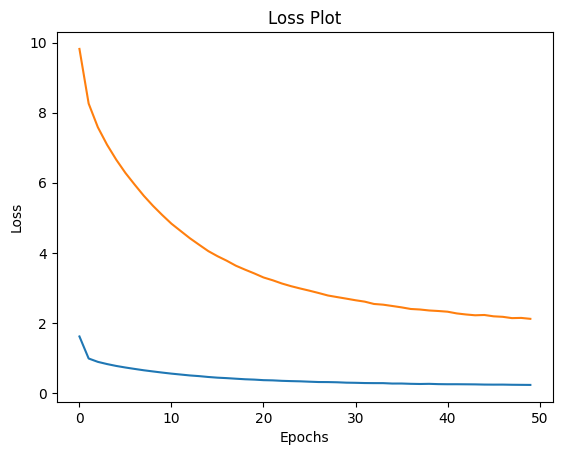

In [43]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

### Greedy Search

In [44]:
features_shape = batch_f.shape[1]
attention_features_shape = batch_f.shape[0]

In [45]:
def evaluate(image):
    max_length = 39
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_and_process_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)
    
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot, predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, predictions

In [46]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [47]:
from nltk.translate.bleu_score import sentence_bleu

In [48]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [49]:
def testing(weights=(0.25,0.25,0.25,0.25), image_number = 0):
    if image_number:
        rid = image_number
    else:
        rid = np.random.randint(0, len(path_test))
    test_image = path_test[rid]

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    result, attention_plot,pred_test = evaluate(test_image)

    real_caption=filt_text(real_caption)      

    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    pred_caption = pred_caption.replace('<unk>','')
    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = sentence_bleu(reference, candidate, weights= weights) #set your weights
    print(rid)
    print(f"BELU score: {score*100}")

    print('Real Caption:', real_caption)
    print('Prediction Caption:', pred_caption)
    plot_attmap(result, attention_plot, test_image)

    #TTS
    myobj = gTTS(text=pred_caption, lang='en', slow=False)

    audio_file_name = "text_to_speech.mp3"

    myobj.save(audio_file_name)

    display.display(display.Audio(audio_file_name, rate=None,autoplay=False))

    return(test_image)

36038
BELU score: 100.0
Real Caption: a child wearing a blue shirt is jumping in the air
Prediction Caption: a child wearing a blue shirt is jumping in the air


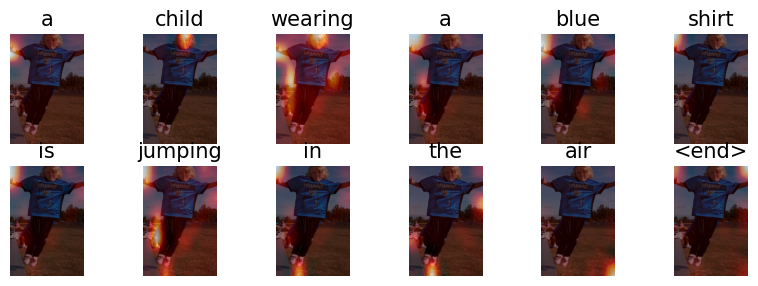

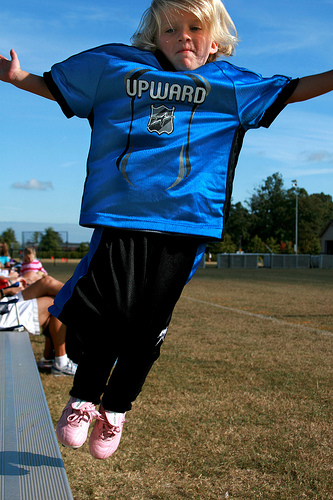

In [63]:
test_image = testing()
Image.open(test_image)

32318
BELU score: 100.0
Real Caption: a baby in a baby seat wearing a red beanie that says love
Prediction Caption: a baby in a baby seat wearing a red beanie that says love


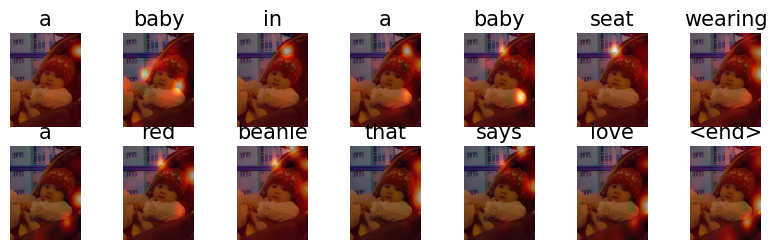

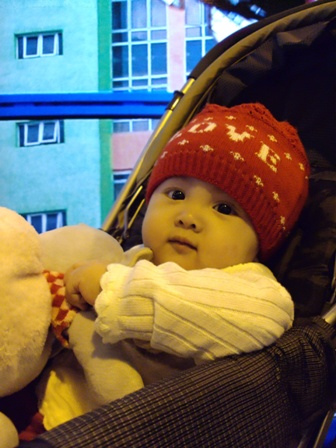

In [58]:
test_image = testing(weights=(0.5,0.5,0.5,0.5))
Image.open(test_image)

29845
BELU score: 77.45966692414834
Real Caption: a dog that is down in water is shaking off
Prediction Caption: a brown dog is in the water shaking its head


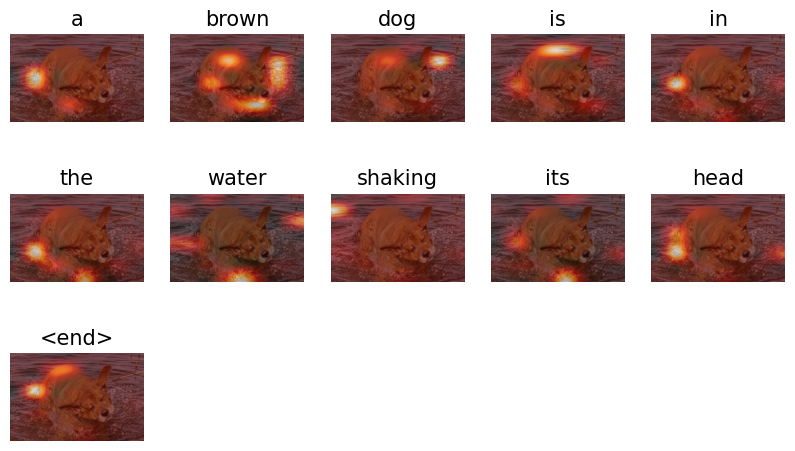

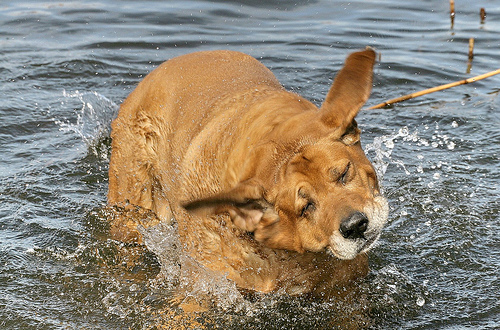

In [66]:
test_image = testing(weights=(0.5,0.5,0.5,0.5))
Image.open(test_image)

27332
BELU score: 60.30226891555272
Real Caption: a lone skateboarder skating down a rail near some stairs
Prediction Caption: a skateboarder sliding down slide at a stairway with his skateboard


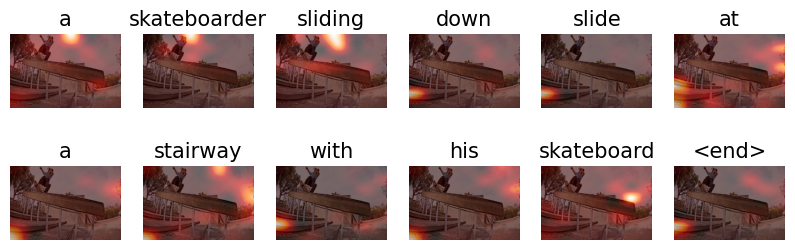

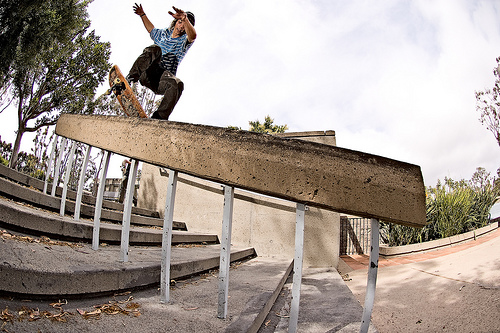

In [74]:
test_image = testing(weights=(0.5, 0.5 , 0.5, 0.5))
Image.open(test_image)

35420
BELU score: 65.14390575310556
Real Caption: a brown dog runs through the water in the ocean
Prediction Caption: a brown dog runs through the water


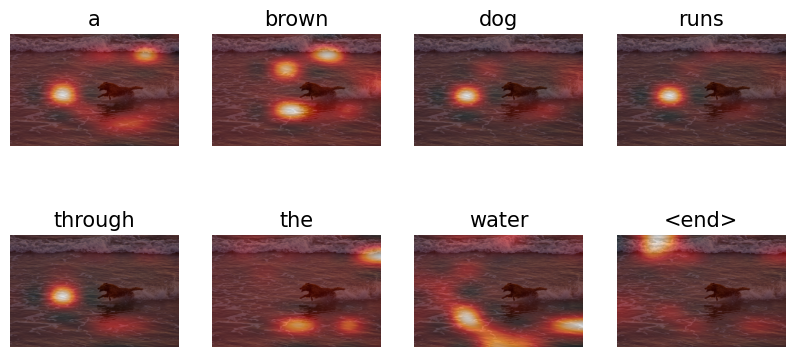

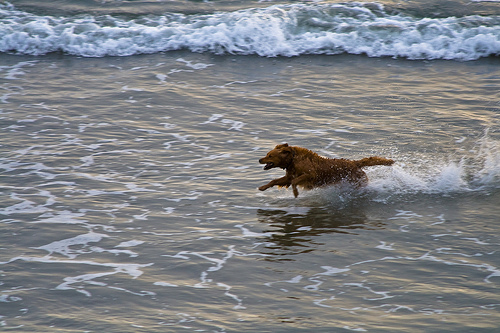

In [151]:
test_image = testing(weights=(0.5, 0.5 , 0.5, 0.5))
Image.open(test_image)

35539
BELU score: 100.0
Real Caption: a man sitting in a chair smoking a cigarette
Prediction Caption: a man sitting in a chair smoking a cigarette


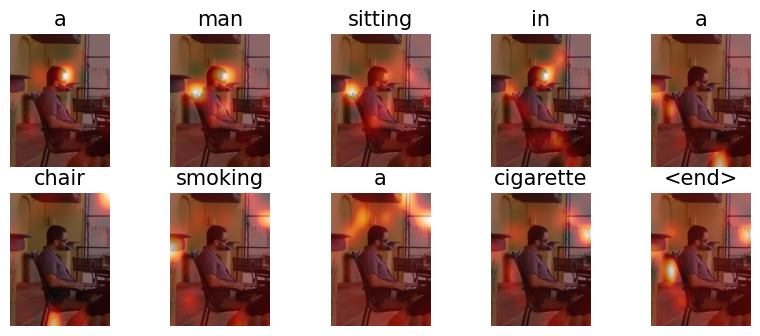

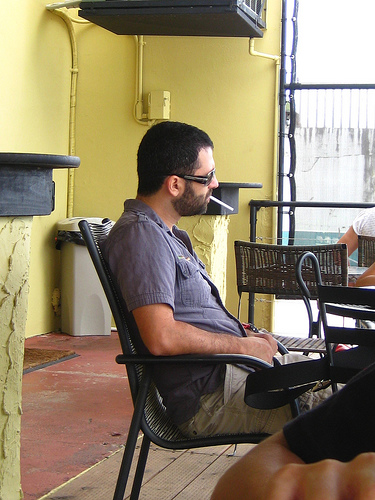

In [138]:
test_image = testing(weights=(0.25, 0.25 , 0.25, 0))
Image.open(test_image)

20002
BELU score: 68.65890479690393
Real Caption: jockey and horse jump over blue hurdle
Prediction Caption: a man is riding a horse over a course


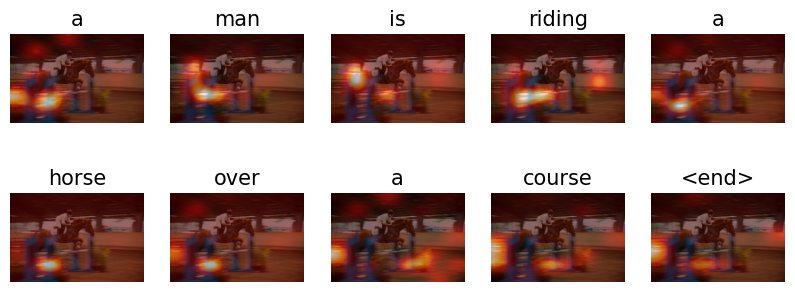

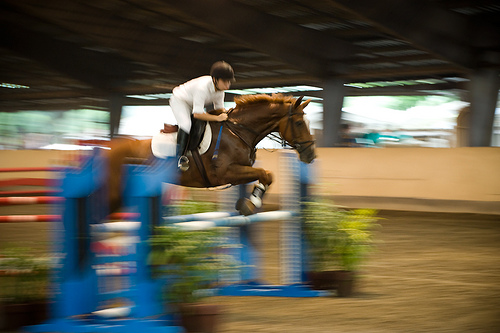

In [131]:
test_image = testing(weights=(0.25, 0.25 , 0.25, 0.25))
Image.open(test_image)

33620
BELU score: 100.0
Real Caption: a girl plays her guitar on a dark stage
Prediction Caption: a girl plays her guitar on a dark stage


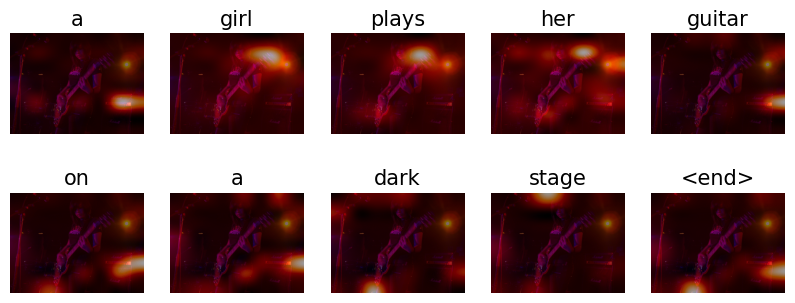

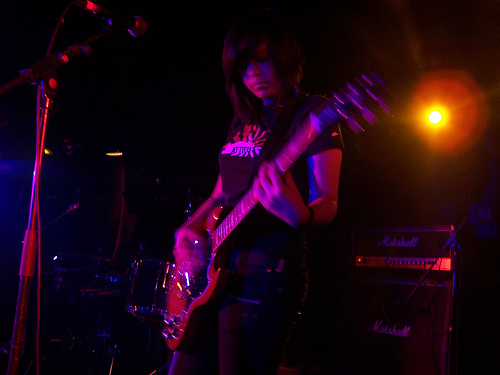

In [124]:
test_image = testing(weights=(0.5,0.5,0.5,0.5))
Image.open(test_image)

25705
BELU score: 100.0
Real Caption: a person attached to a harness is being dragged through the water
Prediction Caption: a person attached to a harness is being dragged through the water


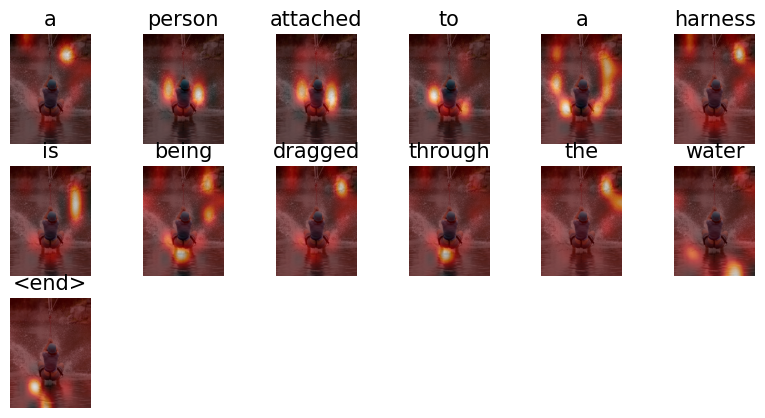

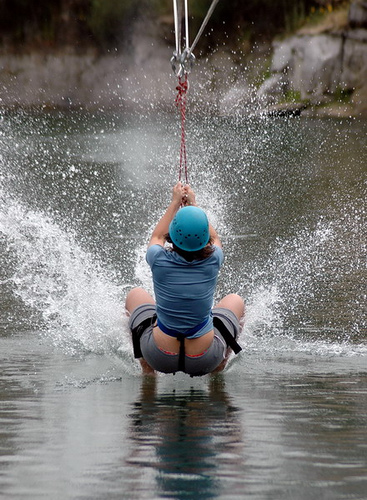

In [110]:
test_image = testing(weights=(0.5,0.5,0.5,0.5))
Image.open(test_image)

17833
BELU score: 65.46536707079771
Real Caption: bicycles in a race
Prediction Caption: a group of people in bike race


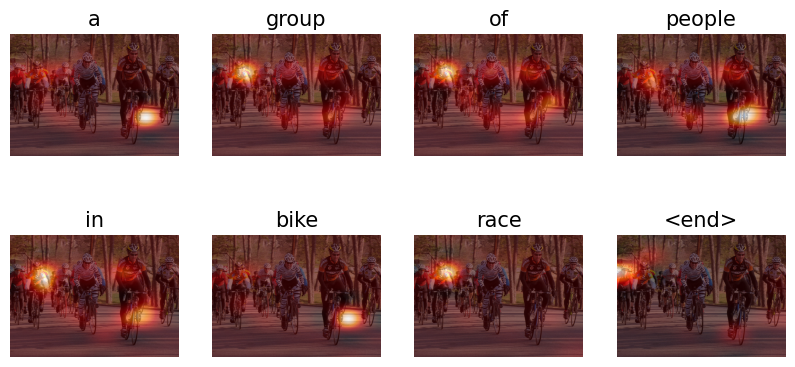

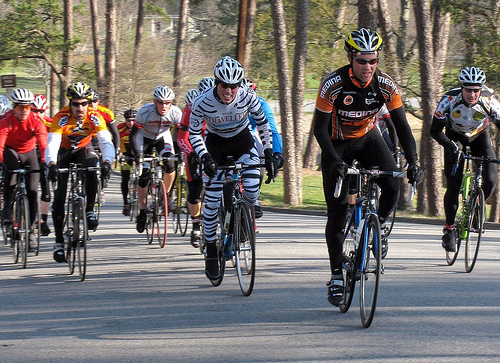

In [106]:
test_image = testing(weights=(0.5,0.5,0.5,0.25))
Image.open(test_image)

7495
BELU score: 67.4199862463242
Real Caption: a small dog on a leash jumps toward a pink ball
Prediction Caption: a white and brown dog jumps while holding a red ball


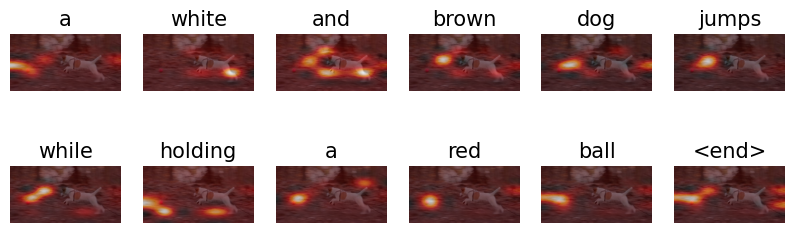

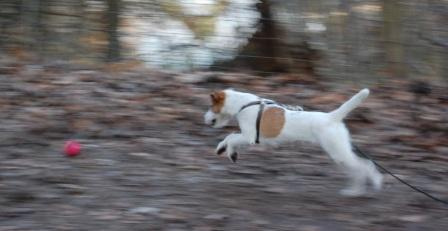

In [103]:
test_image = testing(weights=(0.5,0.25,0.5,0.5))
Image.open(test_image)

4238
BELU score: 77.45966692414834
Real Caption: a man in a yellow boat paddling down rough waters
Prediction Caption: a person in a yellow kayak is descending rough waters


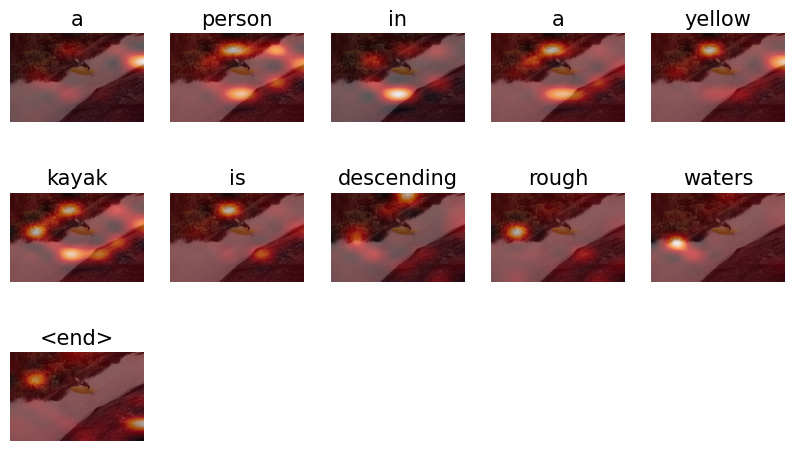

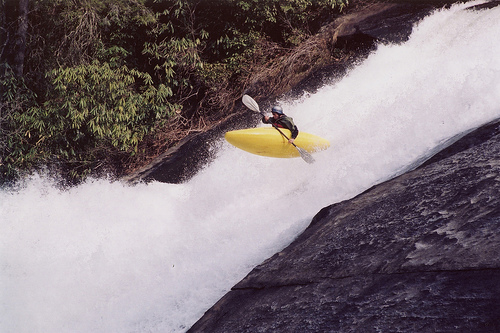

In [99]:
test_image = testing(weights=(0.5,0,0,0))
Image.open(test_image)